In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib.colors import Normalize
import sys

In [3]:
def print_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█'):
    """
    Call in a loop to create a terminal progress bar.
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r{prefix} |{bar}| {percent}% {suffix}')
    sys.stdout.flush()
    # Print New Line on Complete
    if iteration == total: 
        print()

## 1. Diffusion Limited Aggregation

In [47]:
def diffusion_SOR(initial_grid, objects, tol=1e-5, omega=1.8, max_iter=10000):
    """
    Simulate the 2D diffusion using the Successive Over-Relaxation (SOR) method.
    
    Parameters:
    initial_grid (np.array): The initial grid concentration.
    objects (list of tuples): List of object coordinates in the grid.
    tol (float): The convergence criterion.
    omega (float): The relaxation parameter for SOR.
    max_iter (int): Maximum number of iterations to perform.
    
    Returns:
    np.array: Concentration grid after diffusion process.
    """
    c = np.array(initial_grid) # Copy to avoid modifying the original grid

    for k in range(1, max_iter+1):
        c_old = c.copy()
        for i in range(1, c.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c.shape[1]):
                jp, jm = (j + 1) % c.shape[1], (j - 1) % c.shape[1] # Periodic boundaries                
                if (i,j) in objects:
                    c[i, j] = 0
                else:
                    c[i, j] = (omega/4) * (c[i+1, j] + c[i-1, j] + c[i, jp] + c[i, jm]) + (1 - omega) * c[i, j]

        delta = np.max(np.abs(c - c_old))
        if delta < tol:
            break
        if k == max_iter:
            print(f"No convergence after max iterations {max_iter}")
            break
    
    return c

def simulate_DLA(initial_grid, grid_size, objects, growth_steps, eta, omega):

    steady_state = initial_grid.copy()
    stop_condition = False

    while growth_steps > 0 and stop_condition == False:
        # solve laplace equation
        steady_state = diffusion_SOR(steady_state, objects, omega=omega, tol=1e-5, max_iter=5000)

        # get growth candidates
        growth_objects = []
        growth_concentrations = []
        for i in range(0, grid_size - 1):
            for j in range(grid_size):
                neighbors = [(i - 1, j), (i + 1, j), (i, (j + 1) % grid_size), (i, (j - 1) % grid_size)]
                if (i,j) not in objects and len(set(neighbors).intersection(objects)) > 0:
                    growth_objects.append((i,j))
                    growth_concentrations.append(steady_state[i,j])

        # using the free parameter, modify the growth probabilities
        growth_concentrations = np.maximum(growth_concentrations, 0) # remove negative concentrations
        growth_concentrations = np.array(growth_concentrations) ** eta

        # Choose a random growth object based on concentrations, grow the object
        growth_object = growth_objects[np.random.choice(len(growth_objects), 
                                                        p=growth_concentrations/np.sum(growth_concentrations))]
        objects.append(growth_object)
        steady_state[growth_object[0], growth_object[1]] = 0

        # stop when the object reaches the top of the grid
        if growth_object[0] == grid_size - 2:
            stop_condition = True 
        growth_steps -= 1

    return steady_state, objects

In [55]:
grid_size = 50
initial_grid = np.linspace(0, 1, grid_size).reshape((grid_size, 1)) # linear gradient in the y direction
initial_grid = np.repeat(initial_grid, grid_size, axis=1)
initial_objects = [(0,int(grid_size/2))]
growth_steps = 100
eta = 0 # changing this gives different object shapes
omega = 1.90 # optimal omega for grid size 50 from the previous assignment

final_state, final_objects = simulate_DLA(initial_grid, grid_size, initial_objects, growth_steps, eta, omega)

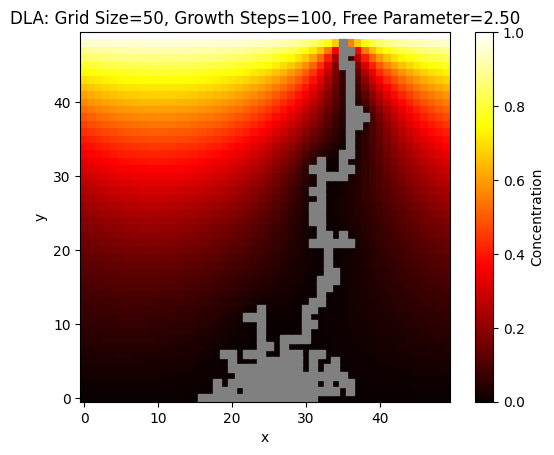

In [61]:
fig, ax = plt.subplots()
cax = ax.imshow(steady_state, cmap='hot', interpolation='nearest', origin='lower')
fig.colorbar(cax, label='Concentration')

# Overlay objects as grey squares
for obj in objects:
    ax.plot(obj[1], obj[0], color='grey', marker = 's')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'DLA: Grid Size={grid_size}, Growth Steps={growth_steps}, Free Parameter={eta:.2f}')
plt.show()


/var/folders/c2/l58_pxzx2tqb1lr7wlj_xt7h0000gn/T/ipykernel_64246/2341608057.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title


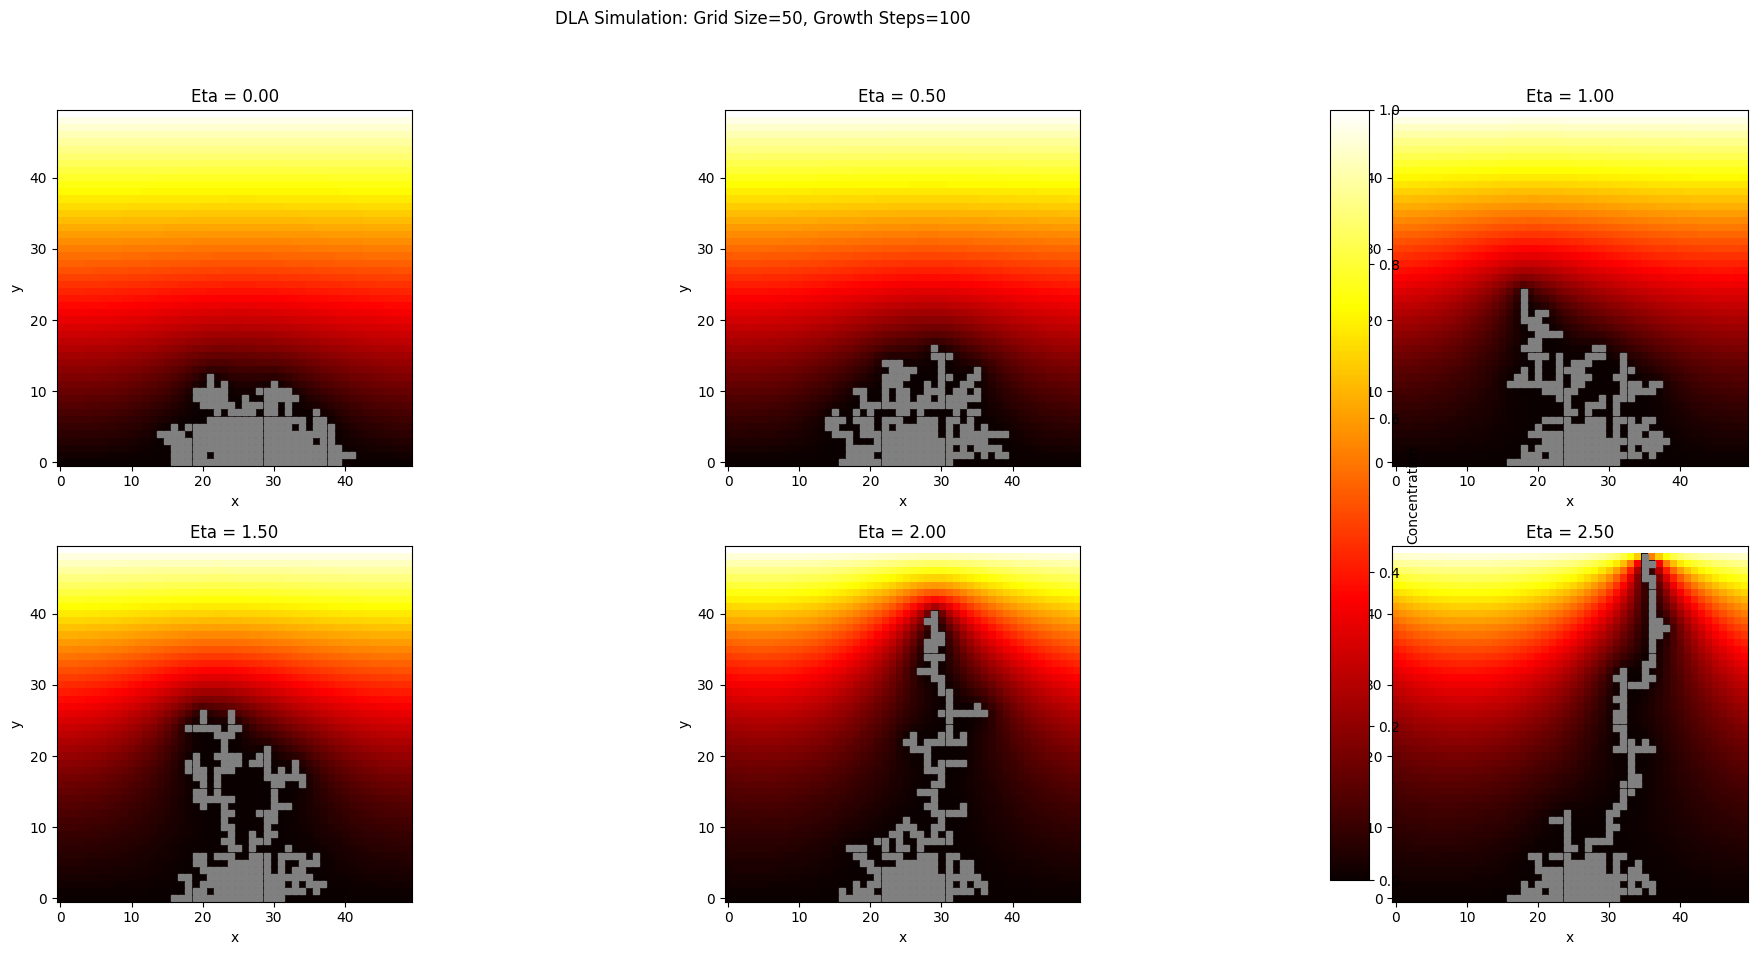

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Assume simulate_DLA, initial_grid, grid_size, initial_objects, growth_steps, omega are defined

etas = [0, 0.5, 1.0, 1.5, 2, 2.5]
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for idx, eta in enumerate(etas):
    row, col = divmod(idx, 3)  # Calculate row and column index
    steady_state, objects = simulate_DLA(np.copy(initial_grid), grid_size, list(initial_objects), growth_steps, eta, omega)

    # Plot the final state for this eta
    cax = axes[row, col].imshow(steady_state, cmap='hot', interpolation='nearest', origin='lower')

    # Overlay objects as dark grey squares
    for obj in objects:
        axes[row, col].plot(obj[1], obj[0], 's', color='grey')  # Use markersize as needed

    axes[row, col].set_title(f'Eta = {eta:.2f}')
    axes[row, col].set_xlabel('x')
    axes[row, col].set_ylabel('y')

# Common colorbar for all subplots
fig.colorbar(cax, ax=axes.ravel().tolist(), label='Concentration')

plt.suptitle(f'DLA Simulation: Grid Size={grid_size}, Growth Steps={growth_steps}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()


## Monte Carlo DLA

In [157]:
def monte_carlo_DLA(initial_grid, grid_size, objects, growth_steps, sticking_probability):
    total_steps = 0
    for i in range(growth_steps):
        print_progress_bar(i + 1, growth_steps, prefix='steps:', suffix='Complete', length=50)
        # find the neighbors of growth objects
        neighbors = []
        for i in objects:
            neighbors += [(i[0]-1,i[1]), (i[0]+1,i[1]), (i[0],(i[1]+1)%grid_size), (i[0],(i[1]-1)%grid_size)]
        # find the growth objects.
        # chose a random point on the top boundary.
        random_walker = (len(initial_grid)-1, np.random.choice(grid_size))
        attached = False
        while not attached:
            possible_steps = [(random_walker[0]-1, random_walker[1]), (random_walker[0]+1, random_walker[1]), (random_walker[0], (random_walker[1]+1)%grid_size), (random_walker[0], (random_walker[1]-1)%grid_size)]
            random_walker_new = possible_steps[np.random.choice(len(possible_steps))]
            # create new random walker if it hits the boundary.
            if random_walker_new[0] == -1 or random_walker_new[0] == grid_size:
                random_walker = (len(initial_grid)-1, np.random.choice(grid_size))
            elif random_walker_new not in objects:
                random_walker = random_walker_new
            total_steps += 1
            if random_walker in neighbors and np.random.rand() < sticking_probability:
                attached = True
        objects.append(random_walker)

    steady_state_monte_carlo = diffusion_SOR(initial_grid, grid_size, objects, omega=1.95, tol=1e-5, max_iter=10000)

    return steady_state_monte_carlo, objects
            

steps: |██████████████████████████████████████████████████| 100.0% Complete


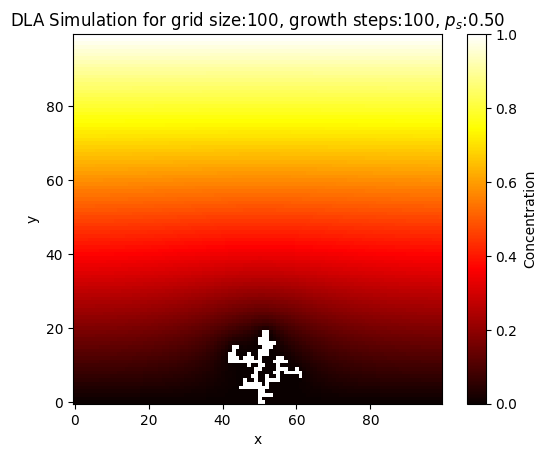

In [159]:
grid_size = 100 # grid size
initial_grid = np.zeros((grid_size,grid_size)) # initial grid
initial_grid[-1,:] = 1 # source at y = N
objects = [(0,int(grid_size/2))] # initial objects
growth_steps = 100 # number of growth steps
free_parameter = 1.5 # free parameter
sticking_probability = 0.5 # sticking probability
final_state, final_objects = monte_carlo_DLA(initial_grid, grid_size, objects, growth_steps, sticking_probability)

# Making objects concentration 1 to visulaize the final state.
for i in range(len(final_objects)):
    final_state[final_objects[i][0], final_objects[i][1]] = 1

fig, ax = plt.subplots()
cax = ax.imshow(final_state, cmap='hot', interpolation='nearest', origin='lower')
fig.colorbar(cax, label='Concentration')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(fr'DLA Simulation for grid size:{grid_size}, growth steps:{growth_steps}, $p_s$:{sticking_probability:.2f}')
plt.show()

## The Gray-Scott model - A reaction-diffusion system